# Initial data and problem exploration



In [1]:
import xarray as xr
import pandas as pd
import urllib.request
import numpy as np
from glob import glob
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import os

In [2]:
import cartopy.feature as cfeature
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')

# Data preprocessing

## TIGGE ECMWF

### Control run

In [3]:
tigge_ctrl = xr.open_mfdataset("/datadrive/tigge/16km/2m_temperature/2019-10.nc")
tigge_ctrl

<xarray.Dataset>
Dimensions:    (init_time: 62, lat: 187, lead_time: 9, lon: 344)
Coordinates:
  * init_time  (init_time) datetime64[ns] 2019-10-01 ... 2019-10-31T12:00:00
  * lead_time  (lead_time) timedelta64[ns] 0 days 00:00:00 ... 2 days 00:00:00
  * lon        (lon) float64 235.0 235.2 235.4 235.5 ... 289.4 289.6 289.8 289.9
  * lat        (lat) float64 49.84 49.68 49.52 49.36 ... 20.56 20.4 20.24 20.08
Data variables:
    t2m        (init_time, lead_time, lat, lon) float32 dask.array<chunksize=(62, 9, 187, 344), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

In [42]:
tigge_ctrl.lat.min()

<xarray.DataArray 'lat' ()>
array(20.08)

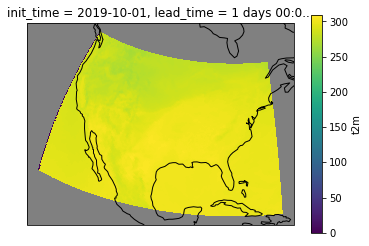

In [47]:
tigge_2dslice = tigge_ctrl.t2m.isel(lead_time=4, init_time=0)
p = tigge_2dslice.plot(   
    subplot_kws=dict(projection=ccrs.Orthographic(-80, 35), facecolor="gray"),
    transform=ccrs.PlateCarree(),)
#p.axes.set_global()
p.axes.coastlines()

### TIGGE CTRL precip

In [49]:
prec = xr.open_mfdataset("/datadrive/tigge/raw/total_precipitation/*.nc")
prec # aggregated precipitation 

<xarray.Dataset>
Dimensions:    (init_time: 825, lat: 214, lead_time: 9, lon: 394)
Coordinates:
  * init_time  (init_time) datetime64[ns] 2019-10-01 ... 2020-11-30T12:00:00
  * lat        (lat) float32 49.97 49.83 49.69 49.55 ... 20.45 20.31 20.17 20.03
  * lon        (lon) float32 235.1 235.2 235.3 235.5 ... 289.6 289.7 289.8 290.0
  * lead_time  (lead_time) timedelta64[ns] 0 days 00:00:00 ... 2 days 00:00:00
Data variables:
    tp         (init_time, lead_time, lat, lon) float32 dask.array<chunksize=(62, 9, 214, 394), meta=np.ndarray>

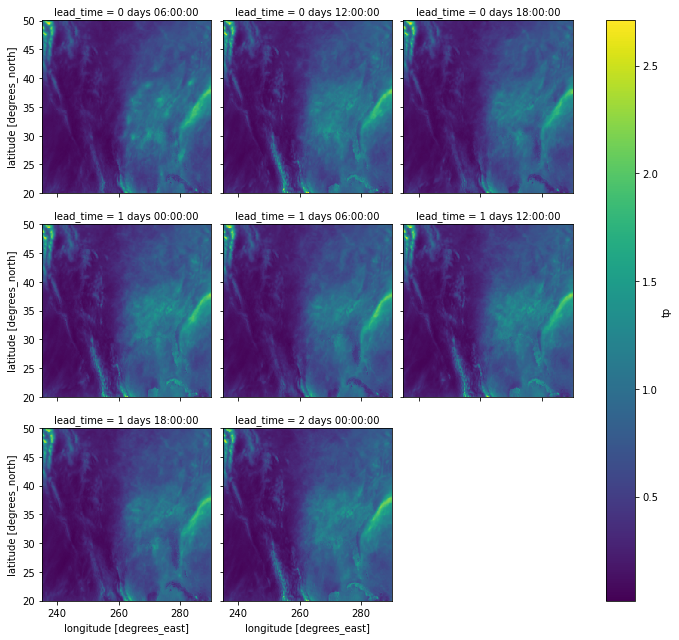

In [66]:
prec.tp.mean('init_time').diff('lead_time').plot(col='lead_time', col_wrap=3) # that takes a while! 

### Checking regridding

In [71]:
t2m_raw = xr.open_mfdataset("/datadrive/tigge/raw/2m_temperature/2019-10.nc")
t2m_32 = xr.open_mfdataset("/datadrive/tigge/32km/2m_temperature/2019-10.nc")
t2m_16 = xr.open_mfdataset("/datadrive/tigge/16km/2m_temperature/2019-10.nc")


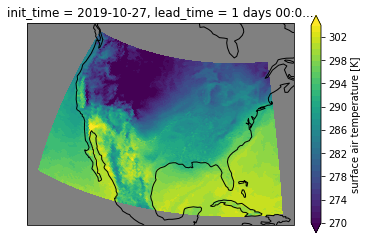

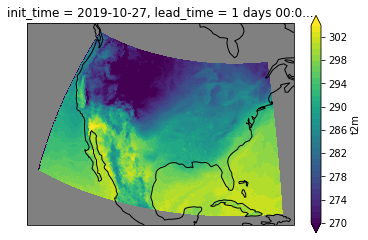

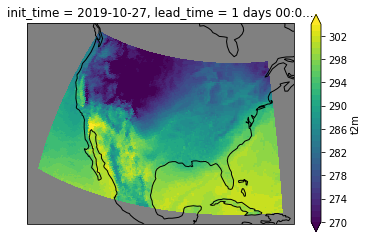

In [84]:
for ds in [t2m_raw, t2m_16, t2m_32]: 
    tigge_2dslice = ds.t2m.isel(lead_time=4, init_time=-10)
    plt.figure()
    p = tigge_2dslice.plot(levels=np.arange(270,305),
        subplot_kws=dict(projection=ccrs.Orthographic(-80, 35), facecolor="gray"),
        transform=ccrs.PlateCarree(),)
    p.axes.coastlines()

### Ensemble

In [ ]:
!ls -lh ../data/tigge/2020-10-23_ens2.grib

In [ ]:
tigge = xr.open_mfdataset('../data/tigge/2020-10-23_ens2.grib', engine='pynio').isel()

In [ ]:
tigge = tigge.rename({
    'tp_P11_L1_GGA0_acc': 'tp', 
    'initial_time0_hours': 'init_time',
    'forecast_time0': 'lead_time',
    'lat_0': 'latitude',
    'lon_0': 'longitude',
    'ensemble0' : 'member'
}).diff('lead_time').tp

In [ ]:
tigge = tigge.where(tigge >= 0, 0)

In [ ]:
# tigge = tigge * 1000   # m to mm

In [ ]:
tigge.coords['valid_time'] = xr.concat([i + tigge.lead_time for i in tigge.init_time], 'init_time')

In [ ]:
tigge

In [ ]:
tigge.to_netcdf('../data/tigge/2020-10-23_ens_preprocessed.nc')

### Deterministic

In [ ]:
tigge = xr.open_mfdataset('../data/tigge/2020-10-23.grib', engine='pynio')

In [ ]:
tigge = tigge.rename({
    'tp_P11_L1_GGA0_acc': 'tp', 
    'initial_time0_hours': 'init_time',
    'forecast_time0': 'lead_time',
    'lat_0': 'latitude',
    'lon_0': 'longitude',
}).diff('lead_time').tp

In [ ]:
tigge = tigge.where(tigge >= 0, 0)

In [ ]:
tigge.coords['valid_time'] = xr.concat([i + tigge.lead_time for i in tigge.init_time], 'init_time')

In [ ]:
tigge

In [ ]:
tigge.to_netcdf('../data/tigge/2020-10-23_preprocessed.nc')

## YOPP

In [ ]:
yopp = xr.open_dataset('../data/yopp/2020-10-23.grib', engine='pynio').TP_GDS4_SFC
yopp2 = xr.open_dataset('../data/yopp/2020-10-23_12.grib', engine='pynio').TP_GDS4_SFC

In [ ]:
yopp = xr.merge([yopp, yopp2]).rename({
    'TP_GDS4_SFC': 'tp', 
    'initial_time0_hours': 'init_time',
    'forecast_time1': 'lead_time',
    'g4_lat_2': 'latitude',
    'g4_lon_3': 'longitude'
})

In [ ]:
yopp = yopp.diff('lead_time').tp

In [ ]:
yopp = yopp.where(yopp >= 0, 0)

In [ ]:
yopp = yopp * 1000   # m to mm

In [ ]:
yopp.coords['valid_time'] = xr.concat([i + yopp.lead_time for i in yopp.init_time], 'init_time')

In [ ]:
yopp.to_netcdf('../data/yopp/2020-10-23_preprocessed.nc')

## NRMS data

In [ ]:
def time_from_fn(fn):
    s = fn.split('/')[-1].split('_')[-1]
    year = s[:4]
    month = s[4:6]
    day = s[6:8]
    hour = s[9:11]
    return np.datetime64(f'{year}-{month}-{day}T{hour}')

In [ ]:
def open_nrms(path):
    fns = sorted(glob(f'{path}/*'))
    dss = [xr.open_dataset(fn, engine='pynio') for fn in fns]
    times = [time_from_fn(fn) for fn in fns]
    times = xr.DataArray(times, name='time', dims=['time'], coords={'time': times})
    ds = xr.concat(dss, times).rename({'lat_0': 'latitude', 'lon_0': 'longitude'})
    da = ds[list(ds)[0]].rename('tp')
    return da

In [ ]:
def get_mrms_fn(path, source, year, month, day, hour):
    month, day, hour = [str(x).zfill(2) for x in [month, day, hour]]
    fn = f'{path}/{source}/MRMS_{source}_00.00_{year}{month}{day}-{hour}0000.grib2'
#     print(fn)
    return fn

In [ ]:
def load_mrms_data(path, start_time, stop_time, accum=3):
    times = pd.to_datetime(np.arange(start_time, stop_time, np.timedelta64(accum, 'h'), dtype='datetime64[h]'))
    das = []
    for t in times:
        if os.path.exists(get_mrms_fn(path, f'MultiSensor_QPE_0{accum}H_Pass1', t.year, t.month, t.day, t.hour)):
            ds = xr.open_dataset(get_mrms_fn(path, f'MultiSensor_QPE_0{accum}H_Pass1', t.year, t.month, t.day, t.hour), engine='pynio')
        elif os.path.exists(get_mrms_fn(path, f'MultiSensor_QPE_0{accum}H_Pass2', t.year, t.month, t.day, t.hour)):
            ds = xr.open_dataset(get_mrms_fn(path, f'MultiSensor_QPE_0{accum}H_Pass2', t.year, t.month, t.day, t.hour), engine='pynio')
        elif os.path.exists(get_mrms_fn(path, f'RadarOnly_QPE_0{accum}H', t.year, t.month, t.day, t.hour)):
            ds = xr.open_dataset(get_mrms_fn(path, f'RadarOnly_QPE_0{accum}H', t.year, t.month, t.day, t.hour), engine='pynio')
        else:
            raise Exception(f'No data found for {t}')
        ds = ds.rename({'lat_0': 'latitude', 'lon_0': 'longitude'})
        da = ds[list(ds)[0]].rename('tp')
        das.append(da)
    times = xr.DataArray(times, name='time', dims=['time'], coords={'time': times})
    da = xr.concat(das, times)
    return da

In [ ]:
mrms = load_mrms_data('../data/', '2020-10-23', '2020-10-25')

In [ ]:
mrms6h = mrms.rolling(time=2).sum().isel(time=slice(0, None, 2))

In [ ]:
mrms.to_netcdf('../data/mrms/mrms_preprocessed.nc')

In [ ]:
mrms6h.to_netcdf('../data/mrms/mrms6_preprocessed.nc')

# Analysis

In [ ]:
tigge_det = xr.open_dataarray('../data/tigge/2020-10-23_preprocessed.nc').rename({'latitude': 'lat', 'longitude': 'lon'})
tigge_ens = xr.open_dataarray('../data/tigge/2020-10-23_ens_preprocessed.nc').rename({'latitude': 'lat', 'longitude': 'lon'})
yopp = xr.open_dataarray('../data/yopp/2020-10-23_preprocessed.nc').rename({'latitude': 'lat', 'longitude': 'lon'})
mrms = xr.open_dataarray('../data/mrms/mrms_preprocessed.nc').rename({'latitude': 'lat', 'longitude': 'lon'})
mrms6h = xr.open_dataarray('../data/mrms/mrms6_preprocessed.nc').rename({'latitude': 'lat', 'longitude': 'lon'})

## Regrid

In [ ]:
import xesmf as xe

In [ ]:
lons = slice(260, 280)
lats = slice(45, 25)

In [ ]:
def regrid(ds, km, lats, lons):
    deg = km/100.
    grid = xr.Dataset(
        {
            'lat': (['lat'], np.arange(lats.start, lats.stop, -deg)),
            'lon': (['lon'], np.arange(lons.start, lons.stop, deg))
        }
    )
    regridder = xe.Regridder(ds.sel(lat=lats, lon=lons), grid, 'bilinear')
    return regridder(ds.sel(lat=lats, lon=lons), keep_attrs=True)

In [ ]:
mrms4km = regrid(mrms, 4, lats, lons)

In [ ]:
mrms2km = regrid(mrms, 2, lats, lons)

In [ ]:
mrms4km6h = regrid(mrms6h, 4, lats, lons)
mrms2km6h = regrid(mrms6h, 2, lats, lons)

In [ ]:
mrms4km6h = mrms4km6h.rename('tp')
mrms2km6h =mrms2km6h.rename('tp')

In [ ]:
yopp16km = regrid(yopp, 16, lats, lons)
yopp32km = regrid(yopp, 32, lats, lons)

In [ ]:
tigge_det16km = regrid(tigge_det, 16, lats, lons)
tigge_det32km = regrid(tigge_det, 32, lats, lons)

In [ ]:
tigge_ens16km = regrid(tigge_ens, 16, lats, lons)
tigge_ens32km = regrid(tigge_ens, 32, lats, lons)

In [ ]:
!mkdir ../data/regridded

In [ ]:
mrms2km.to_netcdf('../data/regridded/mrms2km.nc')
mrms4km.to_netcdf('../data/regridded/mrms4km.nc')
mrms2km6h.to_netcdf('../data/regridded/mrms2km6h.nc')
mrms4km6h.to_netcdf('../data/regridded/mrms4km6h.nc')
yopp16km.to_netcdf('../data/regridded/yopp16km.nc')
yopp32km.to_netcdf('../data/regridded/yopp32km.nc')
tigge_det16km.to_netcdf('../data/regridded/tigge_det16km.nc')
tigge_det32km.to_netcdf('../data/regridded/tigge_det32km.nc')
tigge_ens16km.to_netcdf('../data/regridded/tigge_ens16km.nc')
tigge_ens32km.to_netcdf('../data/regridded/tigge_ens32km.nc')

In [ ]:
mrms2km = xr.open_dataarray('../data/regridded/mrms2km.nc')
mrms4km = xr.open_dataarray('../data/regridded/mrms4km.nc')
mrms2km6h = xr.open_dataarray('../data/regridded/mrms2km6h.nc')
mrms4km6h = xr.open_dataarray('../data/regridded/mrms4km6h.nc')
yopp16km = xr.open_dataarray('../data/regridded/yopp16km.nc')
yopp32km = xr.open_dataarray('../data/regridded/yopp32km.nc')
tigge_det16km = xr.open_dataarray('../data/regridded/tigge_det16km.nc')
tigge_det32km = xr.open_dataarray('../data/regridded/tigge_det32km.nc')
tigge_ens16km = xr.open_dataarray('../data/regridded/tigge_ens16km.nc')
tigge_ens32km = xr.open_dataarray('../data/regridded/tigge_ens32km.nc')

### Matplotlib

#### Compare different resolutions

In [ ]:
mrms4km

In [ ]:
np.arange(lons.start, lons.stop, 512/100)

In [ ]:
def add_grid(axs):
    for ax in axs:
        ax.set_xticks(np.arange(lons.start, lons.stop, 512/100))
        ax.set_yticks(np.arange(lats.start, lats.stop, -512/100))
        ax.grid(True)
        ax.set_aspect('equal')

In [ ]:
yopp16km

In [ ]:
yopp16km.isel(init_time=i, lead_time=slice(0, 3)).valid_time

In [ ]:
i = 3
valid_time = yopp16km.isel(init_time=i, lead_time=slice(0, 3)).valid_time
figsize = (16, 5)
axs = mrms4km.sel(time=valid_time.values).plot(vmin=0, vmax=50, col='time', cmap='gist_ncar_r', figsize=figsize).axes[0]
add_grid(axs)
axs = yopp16km.isel(init_time=i, lead_time=slice(0, 3)).plot(vmin=0, vmax=50, col='lead_time', cmap='gist_ncar_r', figsize=figsize).axes[0]
add_grid(axs)
axs = yopp32km.isel(init_time=i, lead_time=slice(0, 3)).plot(vmin=0, vmax=50, col='lead_time', cmap='gist_ncar_r', figsize=figsize).axes[0]
add_grid(axs)

In [ ]:
i = 2
valid_time = tigge_det16km.isel(init_time=i, lead_time=slice(0, 3)).valid_time
figsize = (16, 5)
axs = mrms4km6h.sel(time=valid_time.values, method='nearest').assign_coords({'time': valid_time.values}).plot(vmin=0, vmax=50, col='time', cmap='gist_ncar_r', figsize=figsize).axes[0]
add_grid(axs)
axs = tigge_det16km.isel(init_time=i, lead_time=slice(0, 3)).plot(vmin=0, vmax=50, col='lead_time', cmap='gist_ncar_r', figsize=figsize).axes[0]
add_grid(axs)
axs = tigge_det32km.isel(init_time=i, lead_time=slice(0, 3)).plot(vmin=0, vmax=50, col='lead_time', cmap='gist_ncar_r', figsize=figsize).axes[0]
add_grid(axs)

In [ ]:
tigge_ens16km.isel(init_time=i, lead_time=l)

In [ ]:
i = 3
l = 0
t = tigge_ens16km.isel(init_time=i, lead_time=slice(l, l+2)).valid_time.values
axs = mrms4km6h.sel(time=t, method='nearest').assign_coords({'time': t}).plot(vmin=0, vmax=50, cmap='gist_ncar_r', figsize=(10, 4), col='time').axes[0]
add_grid(axs)
axs = tigge_ens16km.isel(init_time=i, lead_time=l, member=slice(0, 6)).plot(vmin=0, vmax=50, cmap='gist_ncar_r', figsize=(24, 4), col='member').axes[0]
add_grid(axs)
axs = tigge_ens16km.isel(init_time=i, lead_time=l+1, member=slice(0, 6)).plot(vmin=0, vmax=50, cmap='gist_ncar_r', figsize=(24, 4), col='member').axes[0]
add_grid(axs)

### Holoviews

In [ ]:
import holoviews as hv
hv.extension('bokeh')
hv.config.image_rtol = 1
# from holoviews import opts
# opts.defaults(opts.Scatter3D(color='Value', cmap='viridis', edgecolor='black', s=50))

In [ ]:
lons2 = slice(268, 273)
lats2 = slice(40, 35)
lons2 = lons
lats2 = lats

In [ ]:
def to_hv(da, dynamic=False, opts={'clim': (1, 50)}):
    hv_ds = hv.Dataset(da)
    img = hv_ds.to(hv.Image, kdims=["lon", "lat"], dynamic=dynamic)
    return img.opts(**opts)

In [ ]:
valid_time =  yopp16km.isel(lead_time=slice(0, 4), init_time=slice(0, 3)).valid_time
valid_time2 = tigge_det16km.isel(lead_time=slice(0, 3), init_time=slice(0, 3)).valid_time

In [ ]:
mrms2km_hv = to_hv(mrms2km.sel(time=valid_time, method='nearest').sel(lat=lats2, lon=lons2))
mrms4km_hv = to_hv(mrms4km.sel(time=valid_time, method='nearest').sel(lat=lats2, lon=lons2))
mrms2km6h_hv = to_hv(mrms2km6h.sel(time=valid_time2, method='nearest').sel(lat=lats2, lon=lons2))
mrms4km6h_hv = to_hv(mrms4km6h.sel(time=valid_time2, method='nearest').sel(lat=lats2, lon=lons2))

In [ ]:
yopp16km_hv = to_hv(yopp16km.isel(lead_time=slice(0, 4), init_time=slice(0, 3)).sel(lat=lats2, lon=lons2))
yopp32km_hv = to_hv(yopp32km.isel(lead_time=slice(0, 4), init_time=slice(0, 3)).sel(lat=lats2, lon=lons2))
tigge_det16km_hv = to_hv(tigge_det16km.isel(lead_time=slice(0, 3), init_time=slice(0, 3)).sel(lat=lats2, lon=lons2))
tigge_det32km_hv = to_hv(tigge_det32km.isel(lead_time=slice(0, 3), init_time=slice(0, 3)).sel(lat=lats2, lon=lons2))

### Which resolution for MRMS?

In [ ]:
%%output holomap='widgets'
%%opts Image style(cmap='gist_ncar_r') [width=600, height=600]
# mrms4km6h_hv + tigge_det16km_hv + tigge_det32km_hv
# mrms4km_hv + yopp16km_hv + yopp32km_hv

In [ ]:
%%output holomap='widgets'
%%opts Image style(cmap='gist_ncar_r') [width=600, height=600]
mrms4km_hv + mrms4km6h_hv

In [ ]:
hv_yopp = yopp.isel(init_time=0).sel(latitude=lats, longitude=lons)
hv_yopp.coords['time'] = hv_yopp.init_time + hv_yopp.lead_time
hv_yopp = hv_yopp.swap_dims({'lead_time': 'time'})
# hv_yopp

In [ ]:
hv_mrms = hv.Dataset(mrms.sel(latitude=lats, longitude=lons)[1:])
hv_yopp = hv.Dataset(hv_yopp.sel(time=mrms.time[1:]))

In [ ]:
img1 = hv_mrms.to(hv.Image, kdims=["longitude", "latitude"], dynamic=False)
img2 = hv_yopp.to(hv.Image, kdims=["longitude", "latitude"], dynamic=False)

In [ ]:
%%output holomap='widgets'
%%opts Image style(cmap='gist_ncar_r') plot[colorbar=True]
%%opts Image [width=500, height=400]
img1 + img2

In [ ]:
hv_yopp = yopp.sel(latitude=lats, longitude=lons)
hv_yopp = hv.Dataset(hv_yopp)
img1 = hv_yopp.to(hv.Image, kdims=["longitude", "latitude"], dynamic=False)

In [ ]:
%%output holomap='widgets'
%%opts Image style(cmap='gist_ncar_r') plot[colorbar=True]
%%opts Image [width=500, height=400]
img1

In [ ]:
hv_ds = hv.Dataset(da.sel(latitude=lats, longitude=lons))

In [ ]:
hv_ds

In [ ]:
a = hv_ds.to(hv.Image, kdims=["longitude", "latitude"], dynamic=False)

In [ ]:
a.opts(colorbar=True, fig_size=200, cmap='viridis')

# Old

In [ ]:
path = '../data/MultiSensor_QPE_01H_Pass1/'

In [ ]:
da1 = open_nrms('../data/MultiSensor_QPE_01H_Pass1/')
da3 = open_nrms('../data/MultiSensor_QPE_03H_Pass1/')

In [ ]:
dar = open_nrms('../data/RadarOnly_QPE_03H/')

In [ ]:
da3p = open_nrms('../data/MultiSensor_QPE_03H_Pass2/')

In [ ]:
da1

In [ ]:
da3

In [ ]:
da13 = da1.rolling(time=3).sum()

In [ ]:
(da13 - da3).isel(time=3).sel(latitude=lats, longitude=lons).plot()

In [ ]:
da13.isel(time=slice(0, 7)).sel(latitude=slice(44, 40), longitude=slice(268, 272)).plot(col='time', vmin=0, vmax=50)
plt.suptitle('1h accumulation with rolling(time=3).sum()', y=1.05)

In [ ]:
da3.isel(time=slice(0, 7)).sel(latitude=slice(44, 40), longitude=slice(268, 272)).plot(col='time', vmin=0, vmax=50)
plt.suptitle('3h accumulation', y=1.05)

In [ ]:
dar.isel(time=slice(0, 7)).sel(latitude=slice(44, 40), longitude=slice(268, 272)).plot(col='time', vmin=0, vmax=50)
plt.suptitle('3h accumulation radar', y=1.05)

In [ ]:
da3.isel(time=slice(0, 7)).sel(latitude=slice(44, 43), longitude=slice(269, 270)).plot(col='time', vmin=0, vmax=50)
plt.suptitle('3h accumulation', y=1.05)

In [ ]:
dar.isel(time=slice(0, 7)).sel(latitude=slice(44, 43), longitude=slice(269, 270)).plot(col='time', vmin=0, vmax=50)
plt.suptitle('3h accumulation radar', y=1.05)

In [ ]:
for t in np.arange('2020-10-23', '2020-10-25', np.timedelta64(3, 'h'), dtype='datetime64[h]'):
    print(t)
    print('Radar', (dar.time.values == t).sum() > 0)
    print('Pass1', (da3.time.values == t).sum() > 0)
    print('Pass2', (da3p.time.values == t).sum() > 0)

In [ ]:
t

In [ ]:
(dar.time.values == t).sum() > 0

In [ ]:
da3.time.values

In [ ]:
def plot_facet(da, title='', **kwargs):
    p = da.plot(
        col='time', col_wrap=3,
        subplot_kws={'projection': ccrs.PlateCarree()},
        transform=ccrs.PlateCarree(),
        figsize=(15, 15), **kwargs
    )
    for ax in p.axes.flat:
        ax.coastlines()
        ax.add_feature(states_provinces, edgecolor='gray')
#         ax.set_extent([113, 154, -11, -44], crs=ccrs.PlateCarree())
    plt.suptitle(title);

In [ ]:
plot_facet(da.isel(time=slice(0, 9)).sel(latitude=lats, longitude=lons), vmin=0, vmax=10, add_colorbar=False)

In [ ]:
import holoviews as hv
hv.extension('matplotlib')
from holoviews import opts
opts.defaults(opts.Scatter3D(color='Value', cmap='fire', edgecolor='black', s=50))

In [ ]:
hv_ds = hv.Dataset(da.sel(latitude=lats, longitude=lons))

In [ ]:
hv_ds

In [ ]:
a = hv_ds.to(hv.Image, kdims=["longitude", "latitude"], dynamic=False)

In [ ]:
a.opts(colorbar=True, fig_size=200, cmap='viridis')

In [ ]:
da.longitude.diff('longitude').min()

In [ ]:
!cp ../data/yopp/2020-10-23.nc ../data/yopp/2020-10-23.grib

In [ ]:
a = xr.open_dataset('../data/yopp/2020-10-23.grib', engine='pynio')

In [ ]:
a

In [ ]:
a.g4_lat_2.diff('g4_lat_2')

In [ ]:
a.g4_lon_3.diff('g4_lon_3')

In [ ]:
!cp ../data/tigge/2020-10-23.nc ../data/tigge/2020-10-23.grib

In [ ]:
b = xr.open_dataset('../data/tigge/2020-10-23.grib', engine='pynio')

In [ ]:
b